# Machine Learning to forecast Bitcoin price movements
# Part 1: Obtaining, exploring and preparing the data

As with any other Machine Learning application, the first step is to get and prepare the data for our models.
This notebook will focus in doing precisely this, explaining step by step the data obtained and using graphs to
 visualize these features. At the end of the notebook, we prepare clean data sets,
 which will be stored in the `data/` folder.

## Importing dependencies and utility functions

As described in our project proposal, we will first use historical data from financial data as our data inputs.
For this, we are going to use `yfinance` library, that scrapes this data from Yahoo Finance,
returning it as a pandas dataframe, which will facilitate most of this work, and also we'll use `quandl`.

However, since the tickers mostly have special signs and we want to create an object for each ticker historical data,
I'll first get the data and clear the name to get an appropiate object.

In [1]:
# You need to install quandl and an apikey for this. Only uncomment if you have it 
# %pip install yfinance quandl

In [2]:
# importing commonly used libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# import cufflinks as cf

In [3]:
ma_values = [4,50,80]
rsi_values = {
    'k': 3,
    'd': 3,
    'alpha':14
}

In [4]:
## Let's deal first with the ticker name, this is useful for interpretation

ticker_list = [
#             'SPY',
           '^GSPC',
           '^IXIC', 
           'GC=F', 
           'SI=F',
           'CL=F', 
           '^TNX',
           'BTC-USD',
           '^N225',
           '^ftse', 
           'EURUSD=X',
           '000001.SS', 
           '^HSI',
            ]

signs = ['=','^','-','.']


def change_name(ticker):
    if ticker == 'tnx':
        x = 'rates'
    elif ticker == 'gspc':
        x = 'spy'
    elif ticker == 'sif':
        x = 'silver'
    elif ticker == 'gcf':
        x = 'gold'
    elif ticker == 'ixic':
        x = 'nasdaq'
    elif ticker == 'clf':
        x = 'crude oil'
    elif ticker == 'btcusd':
        x = 'btc'
    elif ticker == 'n225':
        x = 'nikkei'
    elif ticker == 'eurusdx':
        x = 'euro'
    elif ticker == '000001ss':
        x = 'shangai'
    else:
        x = ticker
    return x

gspc = spy
ixic = nasdaq
gcf = gold
sif = silver
clf = crude oil
tnx = rates
btcusd = btc
n225 = nikkei
ftse = ftse
eurusdx = euro
000001ss = shangai
hsi = hsi


### Data transformation utility functions

In [ ]:
def lower_clean_name(word, signs):
    word = word.lower()
    for char in signs:
        word = word.replace(char, '')
    return word

def min_max_scaler(df, log=False):
    if log:
        df = np.log(df)
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df, df.min(), df.max()

def back_min_max(ndf,mindf,maxdf, log=False):
    df = ndf*(maxdf-mindf) + mindf
    if log:
        df = np.exp(df)
    return df

def standardizer(df, log=False):
    '''
    Returns log normalized and standartized df, mean and standard deviation of raw dataframe
    '''
    if log:
        df = np.log(df)
    ndf = (df-df.mean())/df.std()
    return ndf, df.mean(), df.std()

def back_standardizer(ndf, mean, std, log=False):
    df = ndf*std + mean
    if log:
        df = np.exp(df)
    return df

### Technical Indicator funtions
Now we will calculate several indicators typically used in technical analysis of stock prices,
such as simple moving averages, the (stochastic) relative strength index and other statistical measures s.a.
the expanding standard deviation of Bitcoin price.

### Moving Averages

In [ ]:
def transform_ma(data, ma1=4, ma2=50, ma3=80):
    data['MA'+str(ma1)] = round(data['close'].rolling(ma1).mean(),0)
    data['MA'+str(ma2)] = round(data['close'].rolling(ma2).mean(),0)
    data['MA'+str(ma3)] = round(data['close'].rolling(ma3).mean(),0)
    return data

### (Stochastic) Relative Strenght Index

In [ ]:
def transform_rsi(data, alpha=14, smoothK=3, smoothD=3):

    data['change'] = data['close'].pct_change(1)
    data['cum_change'] = (data['change']+1).cumprod()
    data['k'] = 0
    data['d'] = 0

    cond_k = data.change > 0
    cond_d = data.change < 0

    data['k'] = data.k.mask(cond_k, data['change'])
    data['d'] = data.d.mask(cond_d, - data['change'])
    # data['num'] = data['k'].rolling(alpha).mean()

    data['num'] = pd.Series.ewm(data['k'], span=alpha).mean()
    data['div'] = pd.Series.ewm(data['d'], span=alpha).mean()

    # data['div'] = data['d'].rolling(alpha).mean()
    data['rs'] = data['num']/data['div']
    data['RSI'] = (100 - (100/(1+data['rs'])))
    data['RSImin'] = data['RSI'].rolling(alpha).min()
    data['RSImax'] = data['RSI'].rolling(alpha).max()
    data['stochRSI'] = 100*(data['RSI'] - data['RSImin']) / (data['RSImax'] - data['RSImin'])
    data['smoothK'] = round(data['stochRSI'].rolling(smoothK).mean(),2)
    data['smoothD'] = round(data['smoothK'].rolling(smoothD).mean(),2)
    data['K1'] = data['smoothK'].shift(1)
    data['D1'] = data['smoothD'].shift(1)

    # cond_num_zero = data.num == 0
    # data['RSI'] = data.RSI.mask(cond_num_zero, 0)

    # cond_div_zero = data.div == 0
    # data['RSI'] = data.RSI.mask(cond_div_zero, 100)

    return data

def transform_std(df, confidence=80):
    df['btc_std_dev'] = df['change'].expanding(2).std()
    df['btc_mean'] = df['change'].expanding(2).mean()
    # df['conf_int_p'] = np.percentile(df['change'], (100-confidence)/2)
    # df['conf_int_m'] = np.percentile(df['change'], confidence + (100-confidence)/2)
    df['std_dif'] = (df['close'] - df['btc_std_dev']).abs()

    return df

## Start of data gathering

In [ ]:
# test change labels amongst indices
labels = [lower_clean_name(word,signs) for word in ticker_list]
changed_labels = [change_name(x) for x in labels]

for x in range(len(labels)):
    print(labels[x] +' = '+changed_labels[x])

ticker_concat = " ".join(ticker_list)
ohlcv = yf.download(ticker_concat, start="2008-01-01", threads=False)
tickers = yf.download(ticker_concat, start="2008-01-01", group_by='tickers')

In [6]:
ohlcv.tail()

Adj Close                                                  \
              000001.SS       BTC-USD       CL=F  EURUSD=X         GC=F   
Date                                                                      
2022-01-18  3569.909912  42375.632812  85.430000  1.141057  1812.300049   
2022-01-19  3558.179932  41744.328125  86.959999  1.132965  1843.099976   
2022-01-20  3555.060059  40680.417969  86.900002  1.134340  1842.500000   
2022-01-21  3522.570068  36457.316406  85.139999  1.131375  1831.800049   
2022-01-22          NaN  35749.964844        NaN       NaN          NaN   

                                                                             \
                 SI=F        ^FTSE        ^GSPC          ^HSI         ^IXIC   
Date                                                                          
2022-01-18  23.487000  7563.600098  4577.109863  24112.779297  14506.900391   
2022-01-19  24.226000  7589.700195  4532.759766  24127.849609  14340.259766   
2022-01-20  24.711000  7585.000000  4482.729980  24952.349609  14154.019531   
2022-01-21  24.313999  7494.100098  4397.939941  24965.550781  13768.919922   
2022-01-22        NaN          NaN          NaN           NaN           NaN   

                                       Close                           \
                   ^N225   ^TNX    000001.SS       BTC-USD       CL=F   
Date                                                                    
2022-01-18  28257.250000  1.865  3569.909912  42375.632812  85.430000   
2022-01-19  27467.230469  1.827  3558.179932  41744.328125  86.959999   
2022-01-20  27772.929688  1.833  3555.060059  40680.417969  86.900002   
2022-01-21  27522.259766  1.747  3522.570068  36457.316406  85.139999   
2022-01-22           NaN    NaN          NaN  35749.964844        NaN   

                                                                        \
            EURUSD=X         GC=F       SI=F        ^FTSE        ^GSPC   
Date                                                                     
2022-01-18  1.141057  1812.300049  23.487000  7563.600098  4577.109863   
2022-01-19  1.132965  1843.099976  24.226000  7589.700195  4532.759766   
2022-01-20  1.134340  1842.500000  24.711000  7585.000000  4482.729980   
2022-01-21  1.131375  1831.800049  24.313999  7494.100098  4397.939941   
2022-01-22       NaN          NaN        NaN          NaN          NaN   

                                                                    High  \
                    ^HSI         ^IXIC         ^N225   ^TNX    000001.SS   
Date                                                                       
2022-01-18  24112.779297  14506.900391  28257.250000  1.865  3579.310059   
2022-01-19  24127.849609  14340.259766  27467.230469  1.827  3578.729980   
2022-01-20  24952.349609  14154.019531  27772.929688  1.833  3576.260010   
2022-01-21  24965.550781  13768.919922  27522.259766  1.747  3547.000000   
2022-01-22           NaN           NaN           NaN    NaN          NaN   

                                                                       \
                 BTC-USD       CL=F  EURUSD=X         GC=F       SI=F   
Date                                                                    
2022-01-18  42534.402344  86.629997  1.142335  1820.099976  23.487000   
2022-01-19  42478.304688  87.910004  1.135680  1843.099976  24.226000   
2022-01-20  43413.023438  87.820000  1.136893  1843.000000  24.711000   
2022-01-21  41060.527344  85.559998  1.136105  1842.400024  24.313999   
2022-01-22  36685.859375        NaN       NaN          NaN        NaN   

                                                                  \
                  ^FTSE        ^GSPC          ^HSI         ^IXIC   
Date                                                               
2022-01-18  7613.100098  4632.240234  24385.050781  14740.540039   
2022-01-19  7614.899902  4611.549805  24286.140625  14658.889648   
2022-01-20  7619.000000  4602.109863  24952.349609  14642.030273   


In [7]:
tickers.head()

GC=F                                                         \
                  Open        High         Low       Close   Adj Close Volume   
Date                                                                            
2007-12-31  843.200012  843.200012  843.200012  834.900024  834.900024    4.0   
2008-01-01         NaN         NaN         NaN         NaN         NaN    NaN   
2008-01-02  848.700012  857.799988  846.400024  857.000000  857.000000  130.0   
2008-01-03  863.000000  865.500000  856.299988  866.400024  866.400024  181.0   
2008-01-04  861.400024  865.500000  860.200012  863.099976  863.099976   28.0   

                  ^FTSE                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2007-12-31  6476.899902  6480.200195  6432.799805  6456.899902  6456.899902   
2008-01-01          NaN          NaN          NaN          NaN          NaN   
2008-01-02  6456.899902  6512.299805  6402.600098  6416.700195  6416.700195   
2008-01-03  6416.700195  6487.799805  6394.600098  6479.399902  6479.399902   
2008-01-04  6479.399902  6534.700195  6333.200195  6348.500000  6348.500000   

                                ^GSPC                                         \
                  Volume         Open         High          Low        Close   
Date                                                                           
2007-12-31  1.939165e+08  1475.250000  1475.829956  1465.130005  1468.359985   
2008-01-01           NaN          NaN          NaN          NaN          NaN   
2008-01-02  6.740733e+08  1467.969971  1471.770020  1442.069946  1447.160034   
2008-01-03  9.324117e+08  1447.550049  1456.800049  1443.729980  1447.160034   
2008-01-04  1.182498e+09  1444.010010  1444.010010  1411.189941  1411.630005   

                                            CL=F                         \
              Adj Close        Volume       Open        High        Low   
Date                                                                      
2007-12-31  1468.359985  2.440880e+09  96.120003   96.779999  94.730003   
2008-01-01          NaN           NaN        NaN         NaN        NaN   
2008-01-02  1447.160034  3.452650e+09  96.050003  100.000000  96.050003   
2008-01-03  1447.160034  3.429500e+09  99.230003  100.089996  98.449997   
2008-01-04  1411.630005  4.166000e+09  99.169998   99.410004  97.099998   

                                           BTC-USD                           \
                Close  Adj Close    Volume    Open High Low Close Adj Close   
Date                                                                          
2007-12-31  95.980003  95.980003  108597.0     NaN  NaN NaN   NaN       NaN   
2008-01-01        NaN        NaN       NaN     NaN  NaN NaN   NaN       NaN   
2008-01-02  99.620003  99.620003  227099.0     NaN  NaN NaN   NaN       NaN   
2008-01-03  99.180000  99.180000  241269.0     NaN  NaN NaN   NaN       NaN   
2008-01-04  97.910004  97.910004  231790.0     NaN  NaN NaN   NaN       NaN   

                     000001.SS                                         \
           Volume         Open         High          Low        Close   
Date                                                                    
2007-12-31    NaN          NaN          NaN          NaN          NaN   
2008-01-01    NaN          NaN          NaN          NaN          NaN   
2008-01-02    NaN  5265.000000  5295.016113  5201.892090  5272.813965   
2008-01-03    NaN  5269.800781  5321.457031  5211.045898  5319.860840   
2008-01-04    NaN  5328.411133  5372.460938  5318.460938  5361.574219   

                                         ^N225                              \
              Adj Close   Volume          Open          High           Low   
Date                                                                         
2007-12-31          NaN      NaN          

In [8]:
# Renaming columns to changed labels
for x in [ohlcv, tickers]:
    x.rename(columns = lambda x: change_name(lower_clean_name(x,signs)), inplace=True)
    x[x.index.min():]

# ohlcv.rename(columns = lambda x: change_name(lower_clean_name(x,signs)), inplace=True)
# tickers.rename(columns = lambda x: change_name(lower_clean_name(x,signs)), inplace=True)
# ohlcv[ohlcv.index.min():]
# tickers[ohlcv.index.min():]

open = ohlcv['open'].fillna(method='ffill')
high = ohlcv['high'].fillna(method='ffill')
low = ohlcv['low'].fillna(method='ffill')
close = ohlcv['close'].fillna(method='ffill')
volume = ohlcv['volume'].fillna(method='ffill')

In [9]:
# ohlcv.columns

### Strategy to make prices comparable: Returns and cumulative returns

To make stock prices comparable, we first need to bring all of them into the same base.
For this, we will use the `daily returns` of holding this stock. This way, instead of comparing stocks
with different prices (for example, Nikkei starting at 10k USD vs FTSE at 5k USD) we will bring all of them
 to the base of one at the start of the timeframe and record their daily increase or decrease in % to that base.

<AxesSubplot:title={'center':'Returns, excluding BTC [$]'}, xlabel='Date'>

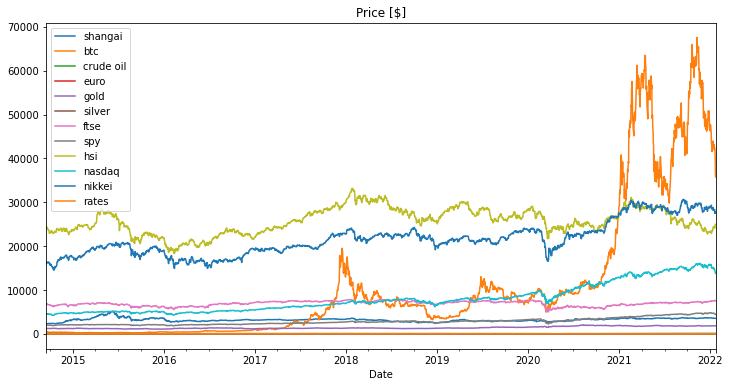

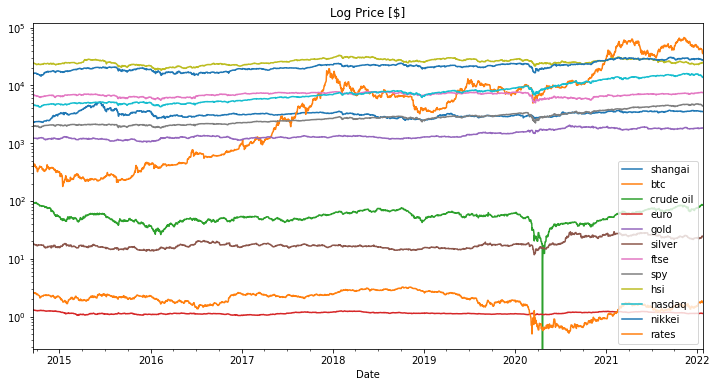

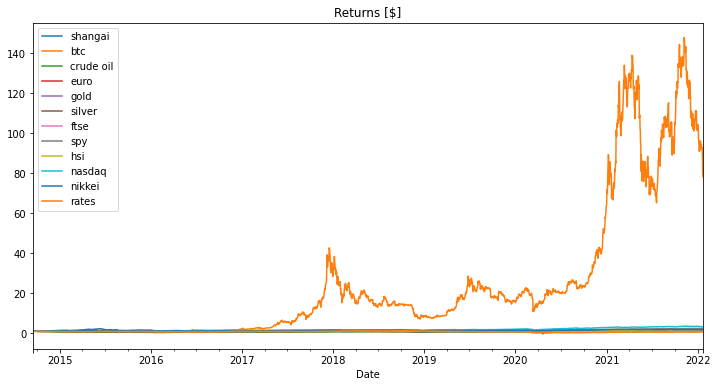

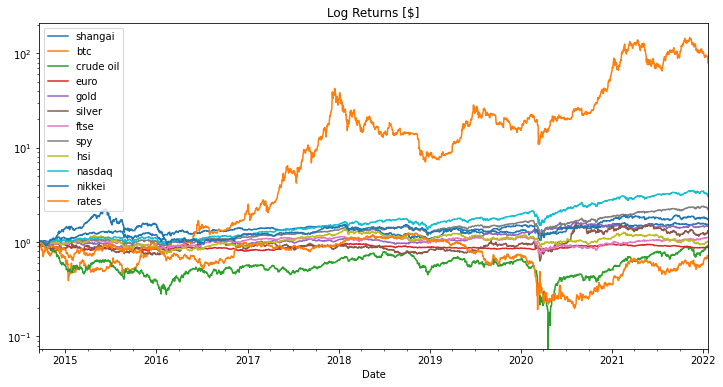

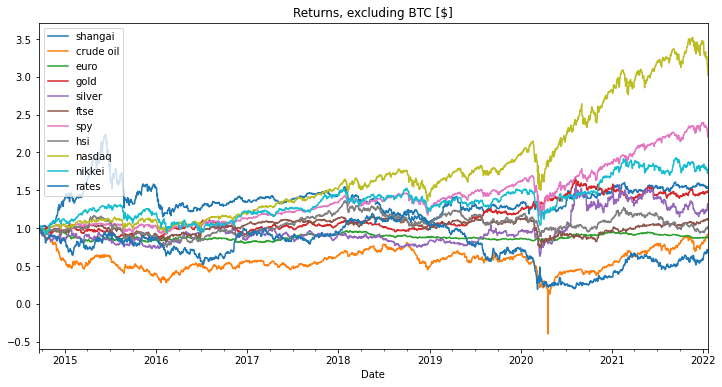

In [10]:
close = close[close.btc.notnull()]
returns = close.pct_change(1)
cumulative = (1 + returns).cumprod()

# For the above, it makes sense to take the logarithm
log_cumulative = np.log(cumulative)

close.plot(figsize=(12,6),label='Price', title='Price [$]')
close.plot(figsize=(12,6),label='Price (log scale)', logy=True, title='Log Price [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns', title='Returns [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns (log)', logy=True, title='Log Returns [$]')

cumulative.loc[:,cumulative.columns != 'btc'].plot(
    figsize=(12,6), label='Cumulative Returns', title='Returns, excluding BTC [$]')

Even by using returns as the base metric, we can see that we needed to plot them in a logarithmic scale,
for their changes to be made comparable with Bitcoin, given the astonishing returns on the asset since 2010.

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>],
       [<AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>],
       [<AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>]], dtype=object)

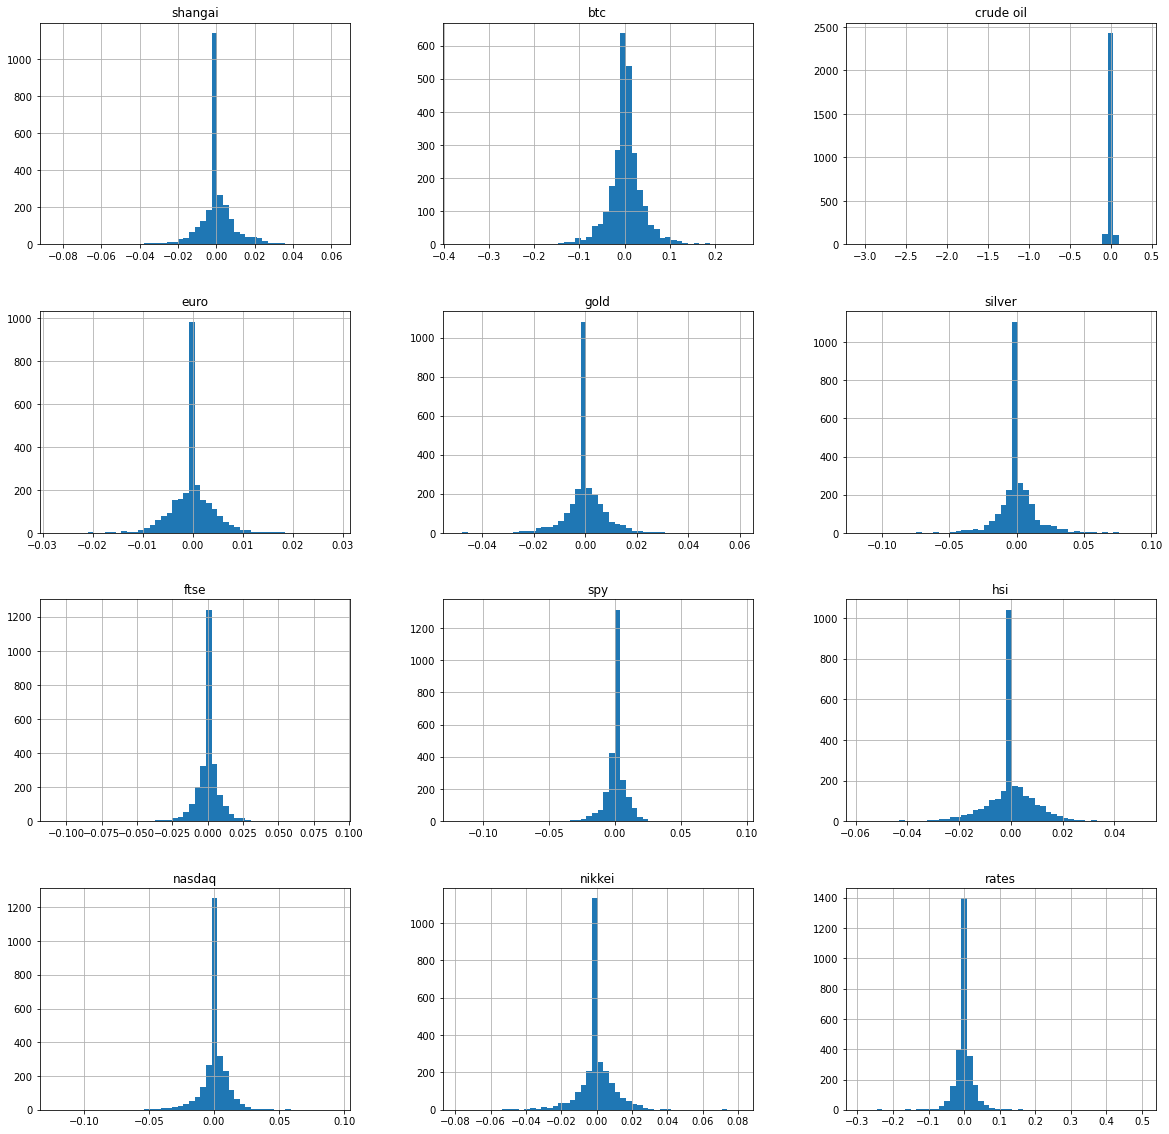

In [11]:
# If returns have a normal distribution, we will use their log
returns.hist(bins=50, figsize=(20,20))

### Applying technical analysis indicators

In [ ]:
### TODO:
### CREATE A BETTER WAY OF PASSING THE FUNCTIONS
ta = tickers.btc
ta = transform_std(transform_rsi(transform_ma(ta, ma_values[0], ma_values[1], ma_values[2])))
ta.tail()

In [16]:
# selection of technical indicators to feed the model
ta = ta[['open', 'high', 'low', 'close',
           f'MA{ma_values[0]}',f'MA{ma_values[1]}', f'MA{ma_values[2]}',
           'stochRSI', 'RSI','btc_std_dev','std_dif']].fillna(method='bfill')

### Exploring volume data

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>],
       [<AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>],
       [<AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>]], dtype=object)

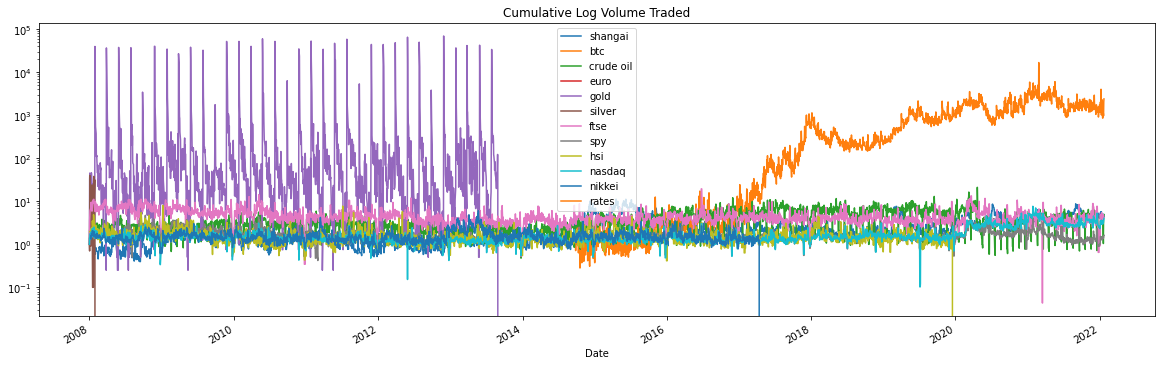

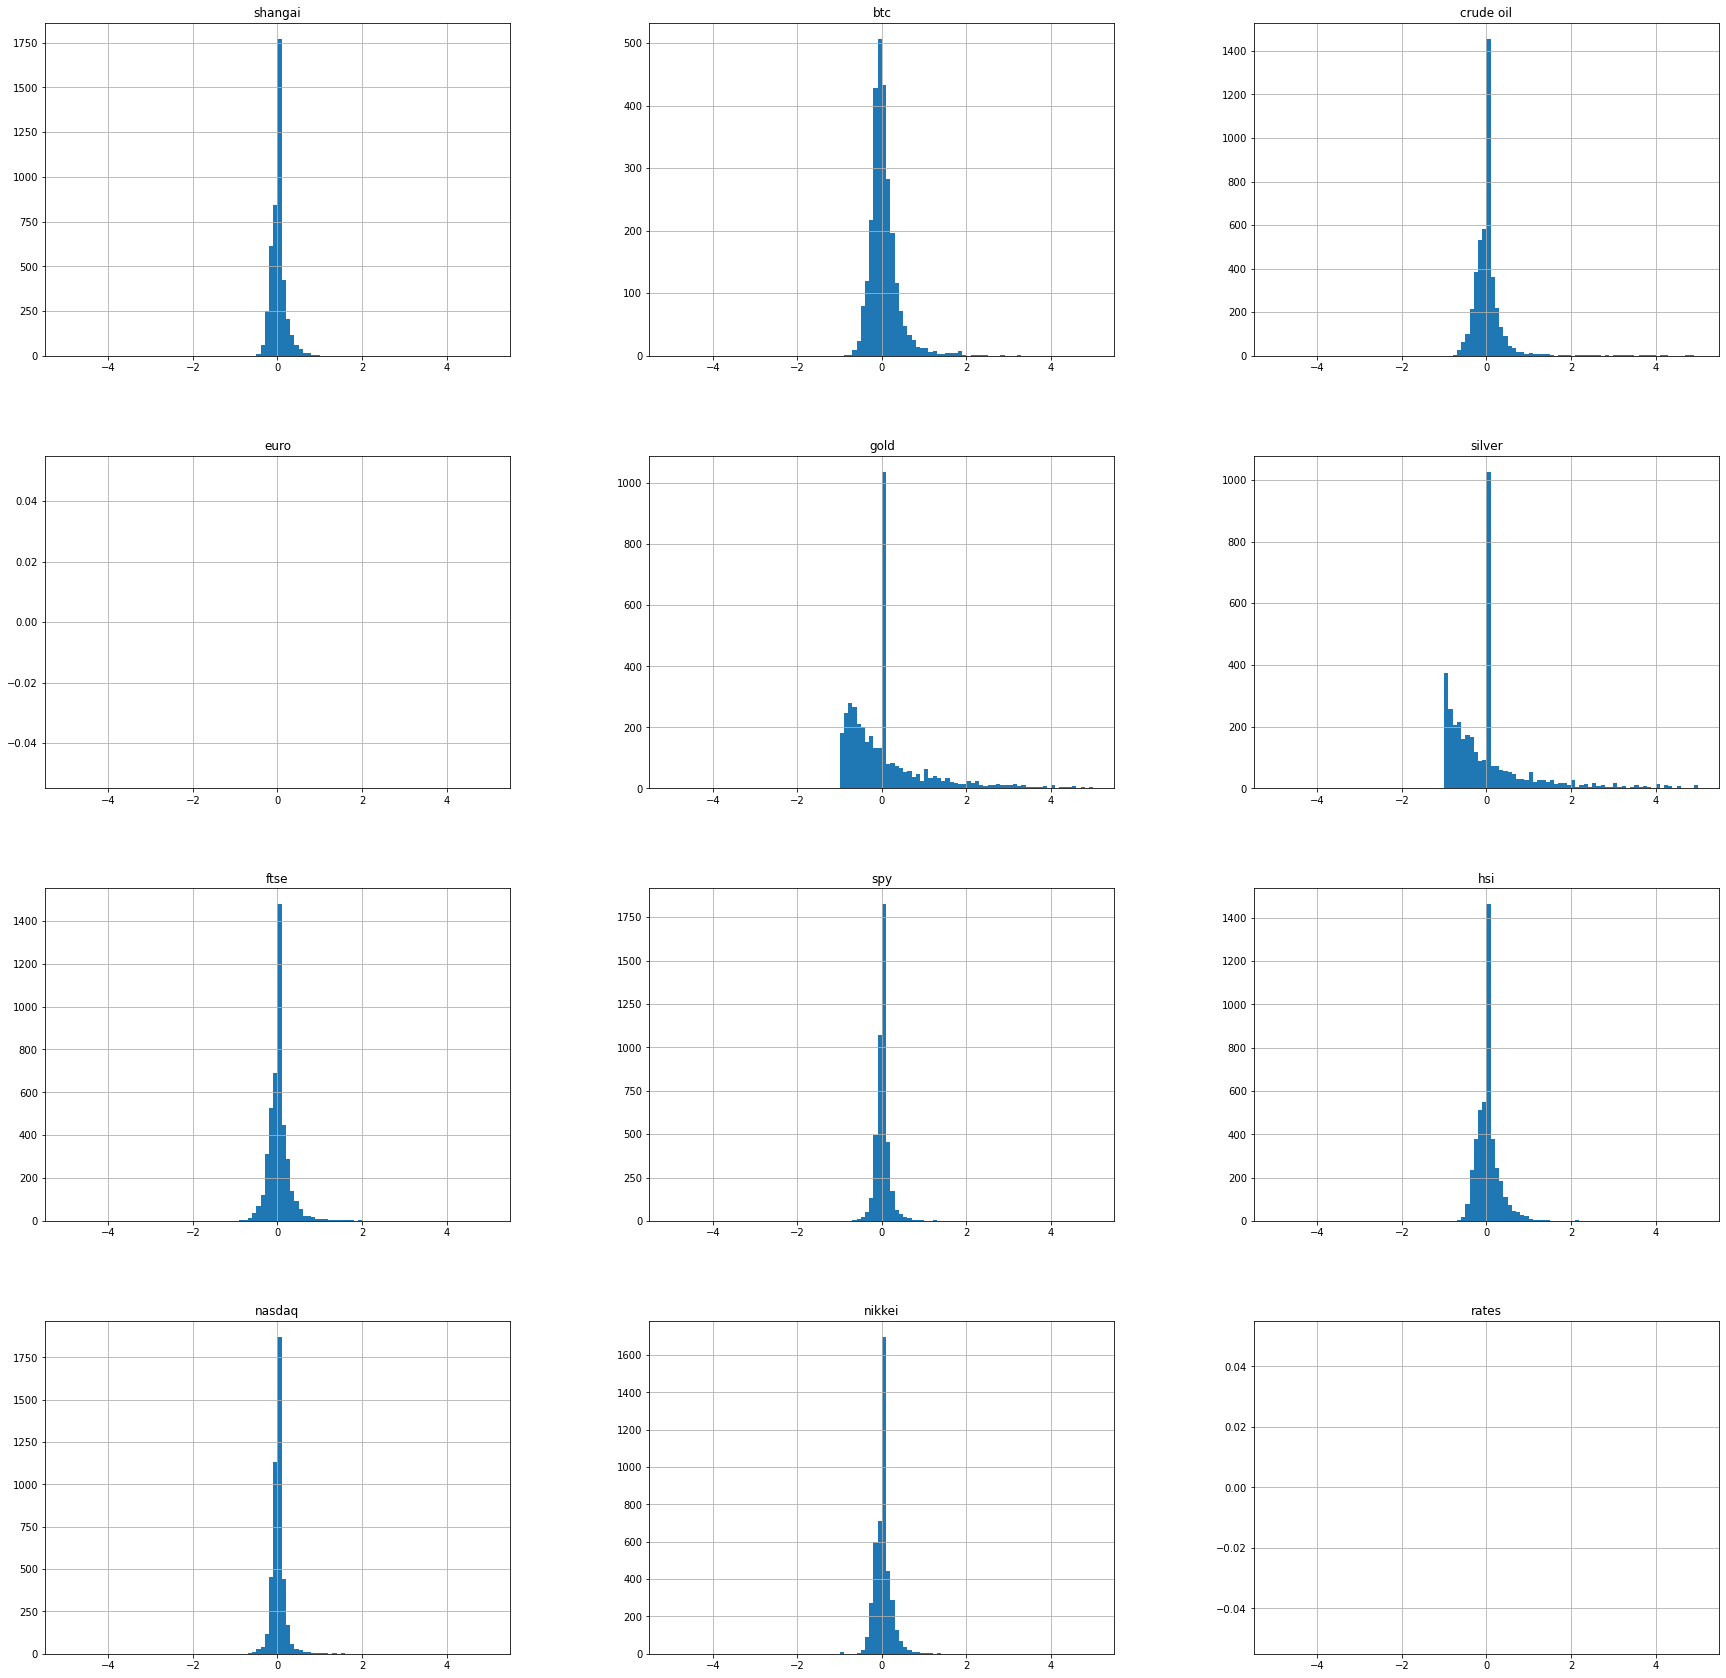

In [18]:
# volume.plot(logy=True, figsize=(20,6))
v_returns = volume.pct_change(1)
v_cumulative = (1+v_returns).cumprod()
v_cumulative.plot(logy=True, figsize=(20,6), title="Cumulative Log Volume Traded")
v_returns.hist(bins=100, figsize=(30,30), range=[-5, 5])

In [19]:
volume.drop(columns=['rates', 'euro'], inplace=True)
volume.columns

Index(['shangai', 'btc', 'crude oil', 'gold', 'silver', 'ftse', 'spy', 'hsi',
       'nasdaq', 'nikkei'],
      dtype='object')

In [20]:
volume.rename(columns = lambda x: "vol_" + x, inplace=True)
volume.tail()

,vol_shangai,vol_btc,vol_crude oil,vol_gold,vol_silver,vol_ftse,vol_spy,vol_hsi,vol_nasdaq,vol_nikkei
Date,,,,,,,,,,
2022-01-18,377100.0,2.241721e+10,163643.0,900.0,207.0,953228000.0,3.324960e+09,1.638866e+09,5.027990e+09,71300000.0
2022-01-19,333200.0,2.309154e+10,113153.0,4.0,3.0,867104400.0,3.387370e+09,1.729895e+09,4.639990e+09,84300000.0
2022-01-20,379500.0,2.038203e+10,532202.0,20.0,21.0,786613700.0,3.473060e+09,2.531395e+09,5.078450e+09,74000000.0
2022-01-21,326500.0,4.301199e+10,532202.0,20.0,21.0,819199800.0,3.945810e+09,2.370147e+09,5.845830e+09,72700000.0
2022-01-22,326500.0,5.019454e+10,532202.0,20.0,21.0,819199800.0,3.945810e+09,2.370147e+09,5.845830e+09,72700000.0


In [21]:
volume.describe()

,vol_shangai,vol_btc,vol_crude oil,vol_gold,vol_silver,vol_ftse,vol_spy,vol_hsi,vol_nasdaq,vol_nikkei
count,4435.000000,2.685000e+03,4.437000e+03,4437.000000,4437.000000,4.437000e+03,4.437000e+03,4.435000e+03,4.437000e+03,4.433000e+03
mean,192385.862458,1.461574e+10,4.144351e+05,5681.064458,1789.841109,8.566955e+08,3.991992e+09,1.893555e+09,2.432304e+09,1.218544e+08
std,127530.379166,2.009591e+10,2.126928e+05,30176.102568,9868.877713,3.382439e+08,1.176841e+09,7.451943e+08,1.157819e+09,5.417916e+07
min,30400.000000,5.914570e+06,4.851600e+04,0.000000,0.000000,8.378200e+06,1.025000e+09,0.000000e+00,1.494100e+08,0.000000e+00
25%,102200.000000,7.847780e+07,2.591590e+05,41.000000,8.000000,6.574006e+08,3.273050e+09,1.421452e+09,1.790280e+09,7.880000e+07
50%,154600.000000,5.002962e+09,3.605740e+05,141.000000,42.000000,7.866144e+08,3.709050e+09,1.736227e+09,2.032040e+09,1.181000e+08
75%,246800.000000,2.445711e+10,5.471900e+05,474.000000,154.000000,9.734622e+08,4.441040e+09,2.172105e+09,2.475160e+09,1.500000e+08
max,857100.000000,3.509679e+11,2.288230e+06,386334.000000,170297.000000,3.761301e+09,1.145623e+10,9.799120e+09,1.110216e+10,5.952000e+08


The problem with using volume data, seems that it is that not all instruments have it available,
plus we are not sure whether this is on the same measure value (USD). For this we will only take BTC.

### Getting fundamental Bitcoin data

Fundamental Bitcoin's blockchain data will also be included, such as hashrate, mining difficulty,
(daily) number of transactions and cost per transaction.

In [23]:
import quandl
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

# from settings import QUANDLKEY
quandl_key = os.getenv("QUANDLKEY")
quandl.ApiConfig.api_key = quandl_key # (insert if available, else there is a ratelimit)

In [24]:
# print('This is your key!', quandl_key)

In [67]:

# btc mining is an interesting source, but free data has not the same quality ;)
# btcmining = quandl.get('BITCOINWATCH/MINING') # total btc and marketcap, bad quality data
# btcmining.fillna(method='ffill').plot(legend=None, logy=True)

btc_hrate = quandl.get('BCHAIN/HRATE') # hashrate
btc_diff = quandl.get('BCHAIN/DIFF') # difficulty
btc_ntrat = quandl.get('BCHAIN/NTRAT') # number of transactions
btc_cptra = quandl.get('BCHAIN/CPTRA') # cost per transaction
m2 = quandl.get("FED/M2_N_WM")
# m2.rename({"Value":"M2"})

fundamentals = pd.concat([btc_hrate, btc_diff, btc_ntrat, btc_cptra], axis=1) #, m2]
fundamentals.columns = ['hashrate','difficulty','transactions','t_cost'] #, 'm2']
# fundamentals.fillna(method='ffill')

<AxesSubplot:xlabel='Date'>

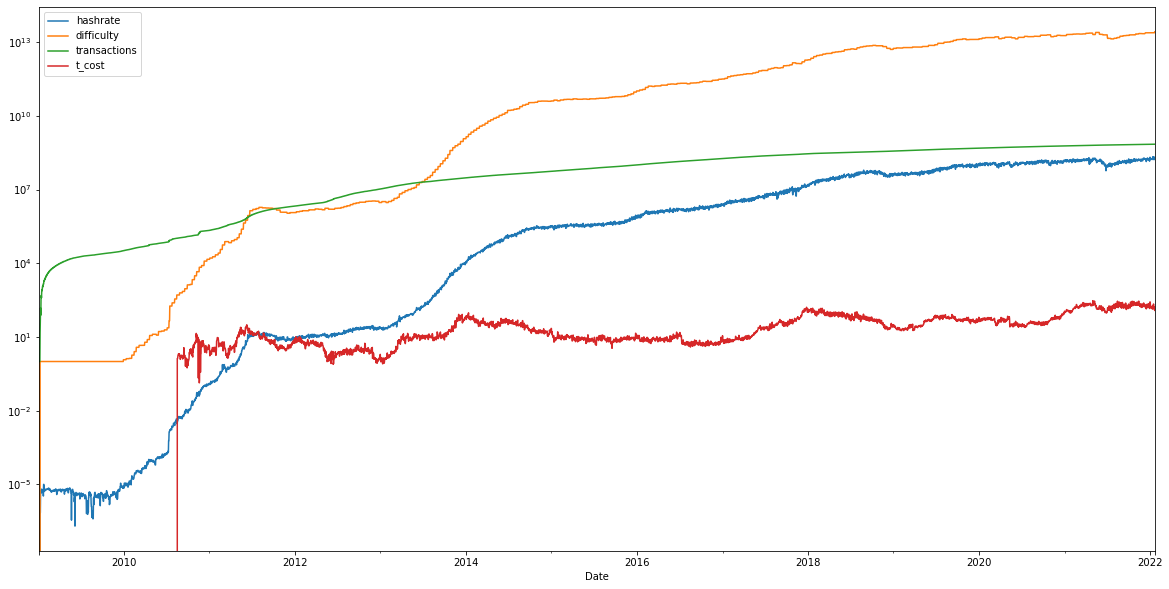

In [68]:
fundamentals.plot(figsize=(20,10), logy=True)

### Joining the data into a single DataFrame

In [ ]:
cumulative = (1 + returns).cumprod()
log_cumulative = np.log(cumulative)

df = pd.concat([log_cumulative, ta], axis=1)
df = pd.concat([df, volume['vol_btc']], axis=1)
df = pd.concat([df, fundamentals], axis=1)
# df.rename(columns={'btc':'btc_cumulative'}, inplace=True)

df.tail()

## Labelling buy, sell and no-trade signals
### Let's reason first what our goal will be here

Following our end-goal, we will need to predict whether prices are going to go up or down.
For this, the condition for the labels will be that if price goes up by more than a certain confidence level it's a buy,
 down a certain confidence level or less a sell, and values in between labelled as no-trade zone.

We will need to shift by one this values to become the predicted labels of our trained model.

In [ ]:
returns.btc.describe()

Given the confidence intervals above, I will take the top 75% interval as buy label (1),
the lowest 25% for the sell label (2), and the values in between as no-trade (0).
The objective of the classification problem will be to **predict the next day's label to give a trading signal**.

In [ ]:
plt.figure(figsize = (15,6))
plt.hist(returns.btc, bins=100)

In [ ]:
print(log_cumulative.columns)
log_cumulative.tail()

### Creating labels

In [ ]:
labels = pd.DataFrame(returns.btc)
labels['y_returns'] = returns.btc
# labels['y_cumulative'] = log_cumulative.btc
labels['y_close'] = ta.close
# labels = pd.concat([labels.returns, log_cumulative.btc, cumulative.btc], axis=1)
# labels = pd.concat([labels])
# labels.rename(columns={'btc':'log_btc_close'}, inplace=True)

In [ ]:
print(labels.columns)
labels.tail()

In [ ]:
buy_cond = labels.returns > labels.y_returns.describe().loc['75%'] # returns.btc.describe()['75%']
sell_cond = labels.returns <  labels.y_returns.describe().loc['25%'] # -0.013636 # returns.btc.describe()['25%']


In [ ]:
labels['y_c'] = 0
labels['y_c'] = labels['y_c'].mask(buy_cond, 1)
labels['y_c'] = labels['y_c'].mask(sell_cond, -1)


# Backtesting, used for later
labels['y_pnl'] = 0
labels['y_pnl'] = labels['y_pnl'].mask(buy_cond, labels.y_returns)
labels['y_pnl'] = labels['y_pnl'].mask(sell_cond, labels.y_returns)
labels.drop(columns=['btc'], inplace=True)

labels.head()

# Finally join our labels with the consolidated DataFrame
df = pd.concat([df,labels], axis=1)

### Data cleaning
I'll consider the minimal available records as starting point and select the training data.
Dates afterwards will be test data. We will also get rid of NA values that aren't useful for our analysis.

In [ ]:
# row data cleaning
# df.describe().loc['count'].min()
print('df ', df.shape)
print(df.index.min())

print('labels ', labels.shape)
print(labels.index.min())

In [38]:
# Take the least available value
df = df[df.index.min():]
# df = df[-int(df.describe().loc['count'].min()):]
df.describe()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,returns,log_btc_cumulative,btc_close,c_label,pnl
count,2684.000000,2684.000000,2683.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,4437.000000,2.685000e+03,4.767000e+03,4.768000e+03,4.768000e+03,4768.000000,2684.000000,2684.000000,2685.000000,2685.000000,2685.000000
mean,0.315463,2.021812,-0.583552,-0.126025,0.116679,-0.045852,0.013930,0.304632,0.047094,0.479690,0.289624,-0.350091,6846.853556,7027.581899,6641.975832,6850.307256,6823.651116,6574.980167,6402.316655,56.827526,33.343891,0.023255,6825.569374,1.461574e+10,2.962989e+07,4.090791e+12,1.925756e+08,34.230831,0.002389,2.021812,11021.811584,0.000000,0.001293
std,0.121005,1.732004,0.259606,0.043139,0.172297,0.190378,0.081220,0.249906,0.115024,0.373432,0.170759,0.405850,13409.735493,13773.597693,12992.109469,13414.419701,13402.345711,13020.376214,12669.110189,27.891467,30.326217,0.017778,13426.222922,2.009591e+10,5.045701e+07,6.969072e+12,2.225108e+08,49.366201,0.038892,1.732004,15916.090163,0.707107,0.038489
min,-0.007842,-0.943052,-2.244168,-0.220907,-0.161033,-0.463967,-0.305893,-0.090119,-0.285645,-0.079471,-0.089218,-1.650661,176.897003,211.731003,171.509995,178.102997,199.000000,232.000000,234.000000,0.000000,0.000000,0.001473,178.061070,5.914570e+06,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,-0.371695,-0.943052,178.102997,-1.000000,-0.371695
25%,0.237983,0.278584,-0.720526,-0.155852,-0.009933,-0.174093,-0.038086,0.061169,-0.030423,0.119692,0.181755,-0.502527,465.864014,468.174011,452.421997,457.334015,421.000000,373.000000,373.000000,41.217877,0.000000,0.001473,394.794517,7.847780e+07,1.233071e+01,1.717649e+06,2.785734e+06,4.616022,-0.013154,0.278584,602.841980,0.000000,0.000000
50%,0.313793,2.614232,-0.574071,-0.133977,0.046535,-0.099348,0.035009,0.292998,0.053941,0.455523,0.285737,-0.235479,465.864014,468.174011,452.421997,457.334015,421.000000,385.000000,373.000000,63.913817,38.238828,0.034066,402.104541,5.002962e+09,3.806471e+05,5.107637e+10,7.624356e+07,10.976255,0.001962,2.614232,6242.193848,0.000000,0.000000
75%,0.388622,3.117227,-0.408435,-0.094101,0.285071,-0.006505,0.078104,0.444049,0.138333,0.681772,0.374784,-0.084009,7417.799805,7574.195801,7270.959961,7422.652832,7397.000000,7475.000000,7718.000000,64.419264,58.952657,0.038880,7422.614247,2.445711e+10,4.285847e+07,5.949437e+12,3.494559e+08,45.172730,0.018264,3.117227,10326.054688,0.000000,0.000000
max,0.805831,4.995458,0.001587,-0.003015,0.507986,0.454384,0.149901,0.873967,0.307551,1.258370,0.657682,0.218208,67549.734375,68789.625000,66382.062500,67566.828125,66121.000000,60802.000000,56971.000000,100.000000,98.422025,0.061565,67566.789052,3.509679e+11,2.168643e+08,2.633808e+13,7.043721e+08,300.310549,0.252472,4.995458,67566.828125,1.000000,0.252472


In [39]:
df.head()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,returns,log_btc_cumulative,btc_close,c_label,pnl
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465.864014,468.174011,452.421997,457.334015,421.0,373.0,373.0,63.913817,0.0,0.001473,394.794517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465.864014,468.174011,452.421997,457.334015,421.0,373.0,373.0,63.913817,0.0,0.001473,394.794517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465.864014,468.174011,452.421997,457.334015,421.0,373.0,373.0,63.913817,0.0,0.001473,394.794517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465.864014,468.174011,452.421997,457.334015,421.0,373.0,373.0,63.913817,0.0,0.001473,394.794517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465.864014,468.174011,452.421997,457.334015,421.0,373.0,373.0,63.913817,0.0,0.001473,394.794517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Fill NAs
df.fillna(method='ffill', inplace=True)

In [41]:
df['returns_label'] = df['y_c']
df['y_c'] = df['y_c'].shift(-1)
df['y_r'] = df['log_btc_cumulative'].shift(-1)

df = df[:-2]
df.tail()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,returns,log_btc_cumulative,btc_close,c_label,pnl,returns_label,r_label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-16,0.422484,4.546186,-0.119081,-0.123185,0.386327,0.205074,0.106510,0.845695,0.000283,1.183139,0.571027,-0.383403,43172.039062,43436.808594,42691.023438,43113.878906,42996.0,47981.0,52888.0,84.511748,44.304268,0.038872,43113.840034,1.790210e+10,2.120182e+08,2.437187e+13,703090105.0,219.597503,-0.001471,4.546186,43113.878906,-1.0,0.000000,0.0,4.525959
2022-01-17,0.428263,4.525959,-0.119081,-0.127244,0.386327,0.205074,0.115511,0.845695,-0.006518,1.183139,0.578439,-0.383403,43118.121094,43179.390625,41680.320312,42250.550781,42910.0,47681.0,52638.0,59.268123,36.683055,0.038867,42250.511914,2.169090e+10,1.950567e+08,2.437187e+13,703305976.0,169.533736,-0.020024,4.525959,42250.550781,0.0,-0.020024,-1.0,4.528915
2022-01-18,0.436205,4.528915,-0.100056,-0.127256,0.384012,0.229904,0.109237,0.827136,-0.010874,1.156822,0.575744,-0.332250,42250.074219,42534.402344,41392.214844,42375.632812,42729.0,47372.0,52394.0,65.246963,38.488105,0.038860,42375.593953,2.241721e+10,1.647684e+08,2.437187e+13,703565724.0,136.294827,0.002960,4.528915,42375.632812,-1.0,0.000000,0.0,4.513905
2022-01-19,0.432914,4.513905,-0.082305,-0.134373,0.400864,0.260883,0.112682,0.817399,-0.010249,1.145268,0.547387,-0.352836,42374.039062,42478.304688,41242.914062,41744.328125,42371.0,47067.0,52150.0,47.141563,33.021968,0.038854,41744.289271,2.309154e+10,2.095951e+08,2.437187e+13,703830844.0,169.617364,-0.014898,4.513905,41744.328125,-1.0,-0.014898,-1.0,4.488088
2022-01-20,0.432037,4.488088,-0.082995,-0.133160,0.400538,0.280706,0.112063,0.806300,0.023352,1.132196,0.558456,-0.349557,41744.027344,43413.023438,40672.824219,40680.417969,41763.0,46736.0,51896.0,23.192338,25.791543,0.038851,40680.379118,2.038203e+10,2.047490e+08,2.437187e+13,704099618.0,170.263707,-0.025486,4.488088,40680.417969,-1.0,-0.025486,-1.0,4.378483


## Data transformations

In order to make try our best so that no feature becomes more important in the dataset than the others,
we will create functions to normalize these and bring them back to the dataset's original state.
This will be used later before saving the feed-in dataset.

We will be using log cumulative returns for price features, and normalize the oscillating factors (i.e. RSI)

<AxesSubplot:title={'center':'Cumulative Returns [$]'}, xlabel='Date'>

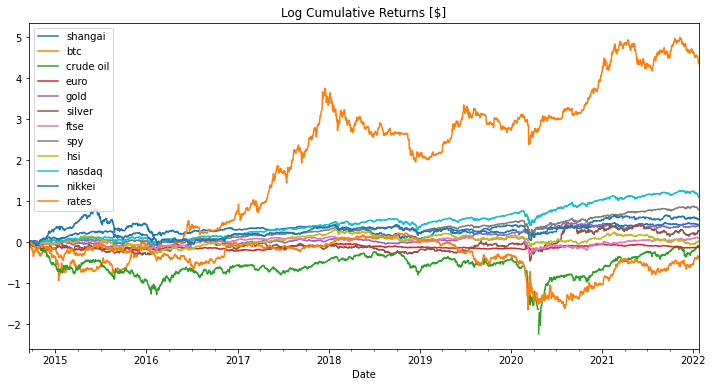

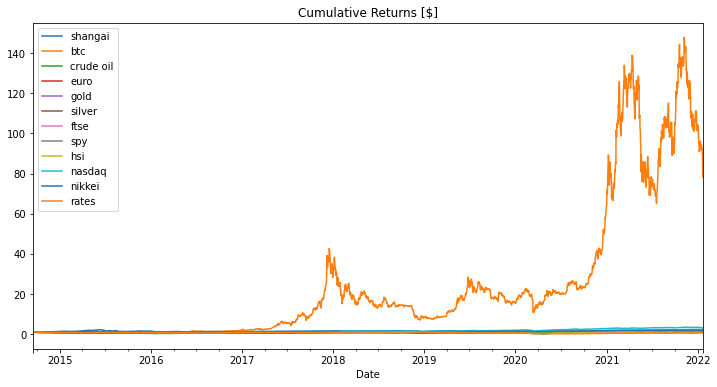

In [42]:
# We can observe that log cumulative returns are reversible. This is useful for predicting price.
log_cumulative.loc[:,:].plot(
    figsize=(12,6), title='Log Cumulative Returns [$]')

np.exp(log_cumulative).plot(figsize=(12,6), title='Cumulative Returns [$]'

Here we will apply the mentioned transformation to features, in a sense que can
revert these to previous values. We will use normalization on log_cumulative (easing a lognormal step),
and normalize and standardize oscillators.

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>],
       [<AxesSubplot:title={'center':'MA80'}>,
        <AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'

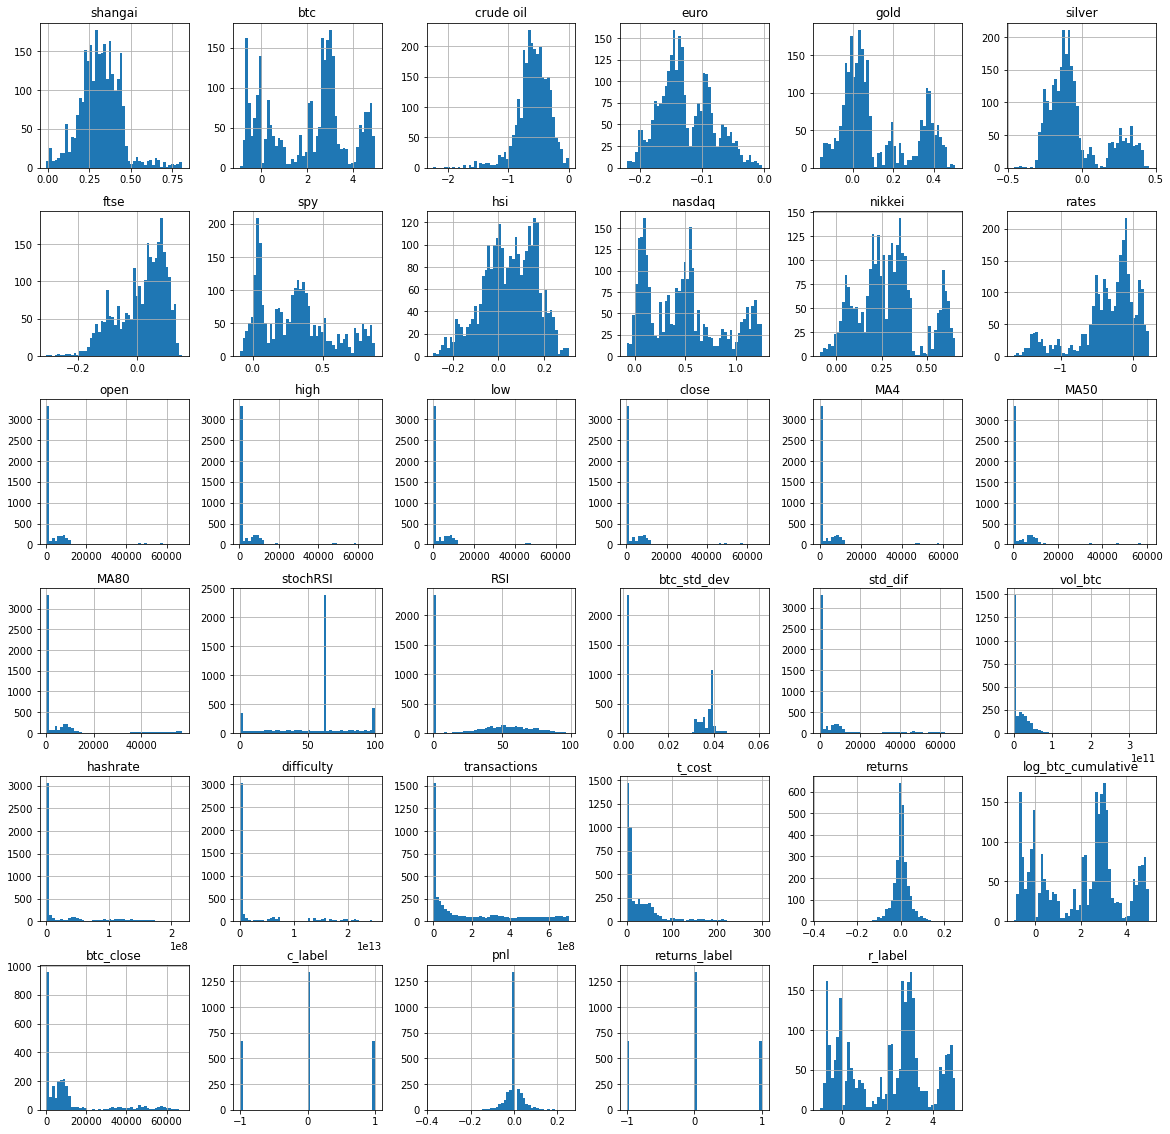

In [45]:
# Have a look at the data
df.hist(bins=50, figsize=(20,20))

In [48]:
# Take cumulative returns of what needs to
cum_cols = ['open', 'high','low',
            'std_dif', f'MA{ma_values[0]}', f'MA{ma_values[1]}', f'MA{ma_values[2]}',
            'hashrate', 'difficulty', 't_cost', 'vol_btc']

df[cum_cols] = (1 + df[cum_cols].pct_change(1)).cumprod()

df.hist(bins=50, figsize=(20,20))

KeyError: "None of [Index([('open', 'high', 'low', 'std_dif', 'MA4', 'MA50', 'MA80', 'hashrate', 'difficulty', 't_cost', 'vol_btc')], dtype='object')] are in the [columns]"

In [ ]:
# Take log of columns that need this
log_cols = ['open', 'high','low',
            'std_dif', f'MA{ma_values[0]}', f'MA{ma_values[1]}', f'MA{ma_values[2]}',
            'hashrate', 'difficulty', 't_cost', 'vol_btc']

df[log_cols] = np.log(df[log_cols])

try:
    df.hist(bins=50, figsize=(20,20))
# except Exception as e:
#     df.hist(bins=25, figsize=(20,20), range=[-100,100])

In [ ]:
# Drop columns that are not needed here
drop_cols = ['close']
df.drop(columns=drop_cols, inplace=True)
df.columns()

In [ ]:
# Normalize what needs be
norm_cols = ['']
# ndf, mindf, maxdf = min_max_scaler(df, log=False)

# Standardize what needs to be. In this case, the whole dataset
standardized_cols = ['']
ndf, mean, std = standardizer(df, log=False)

ndf.hist(bins=50, figsize=(20,20))

In [ ]:
ndf.tail()

## Are these features correlated?

In [ ]:
# Correlation of BTC with features
cor_list = df.corr()['btc'].sort_values(ascending=False).round(2)
cor_list.drop(index=['btc', 'open', 'high', 'low',
    'std_dif', 'MA4', 'y_r', 'MA50', 't_cost',
    'MA80', 'transactions', 'btc_std_dev',
    'RSI', 'y_pnl', 'y_returns', 'stochRSI',
    'returns_label', 'y_c', 'difficulty', 'hashrate', 'log_btc_cumulative'])

In [ ]:
# Normalized correlation does not change, uncomment below to see
# cor_list = ndf.corr()['btc'].sort_values(ascending=False).round(2)
# cor_list.drop(index=['btc', 'open', 'high', 'low',
#     'std_dif', 'MA4', 'y_r', 'MA50', 't_cost',
#     'MA80', 'transactions', 'btc_std_dev',
#     'RSI', 'y_pnl', 'y_returns', 'stochRSI',
#     'returns_label', 'y_c', 'difficulty', 'hashrate', 'log_btc_cumulative'])

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, ax=ax,
            annot=True, 
            cmap="YlGnBu")

In [ ]:
# Description of normalized features
print(ndf.shape)
ndf.describe()

### Saving the data

In [ ]:
# Drop labels and unneeded columns on train & test feature data sets
# drop_list = None
# df.drop(columns=drop_list, inplace=True)

In [ ]:
df_list = [df, ndf, mean, std]
df_path_list = ['data/df.csv', 'data/ndf.csv', 'data/mean.csv', 'data/std.csv']
for (x, y) in zip(df_list, df_path_list):
    x.to_csv(y)

## Recap and Discussion

### What was done?

We started by obtaining and preprocessing the data, specifically:
- Used Quandl and yfinance to source stock market, currencies and Bitcoin fundamentals. 
- Calculated technical analysis indicators, such as simple moving averages, relative strength index (RSI),
- stochastic RSI, cumulated standard deviation and distance to prices.
- Labelled data necessary to provide trading signal predictions later. These labels were selected according to the
- historical distribution of daily Bitcoin returns.
- Created a heatmap to have an initial feeling of correlation between features.
- Cleaned up the data sets for NA values and stored training and testing data.

# What comes next?

In the next notebook, you will find the following sections:

- **Applying AutoML on the data**
- **Training & tuning with Hyperdrive**
